## Installing Libraries

In [ ]:
!pip install transformers[torch] datasets evaluate bleu sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
  Created wheel for bleu: filename=bleu-0.3-py3-none-any.whl size=5782 sha256=6a525293492f3163d7618a7b7c16bc530dc216bf08ee2f34c9f955b6d04c9a78
  Stored in directory: /root/.cache/pip/wheels/c6/d8/d1/009abe01b8b2c6a14c62d197b510b3cc1076014c22d712c5ce
Successfully built bleu


## Connection with Hugging Face

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# Data Loading

In [ ]:
from datasets import load_dataset
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = load_dataset("cfilt/iitb-english-hindi")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1659083 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/520 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2507 [00:00<?, ? examples/s]

In [ ]:
data["train"] = data["train"].select(range(127085))
data = data['train'].train_test_split(test_size = 0.2)
data

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 101668
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 25417
    })
})

# Data Preprocessing

In [ ]:
from transformers import M2M100Tokenizer
model_type = 'facebook/m2m100_418M'
source_lang = "en"
target_lang = "hi"
tokenizer =  M2M100Tokenizer.from_pretrained(model_type,src_lang=source_lang, tgt_lang=target_lang)

tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    inputs = [example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [ ]:
tokenized_data = data.map(preprocess_function, batched=True)
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_type)

Map:   0%|          | 0/101668 [00:00<?, ? examples/s]

Map:   0%|          | 0/25417 [00:00<?, ? examples/s]

# Model Evaluation

In [ ]:
import evaluate
metric = evaluate.load('bleu')

In [ ]:
import numpy as np


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["bleu"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

# Training

In [ ]:
from transformers import M2M100ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = M2M100ForConditionalGeneration.from_pretrained(model_type)
model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="M2M100_hindi",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,0.512800,0.358075,0.668200,13.023800
2,0.327000,0.257140,0.751900,12.933800


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instea

TrainOutput(global_step=3178, training_loss=0.5324713537121359, metrics={'train_runtime': 4123.0667, 'train_samples_per_second': 49.317, 'train_steps_per_second': 0.771, 'total_flos': 1.961457380199629e+16, 'train_loss': 0.5324713537121359, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}


model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1709996380.108e64f04823.423.0:   0%|          | 0.00/7.32k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Anmol1902/M2M100_hindi/commit/2ba35bf03679196b2fb1ac19f6357bc68bfb63a9', commit_message='End of training', commit_description='', oid='2ba35bf03679196b2fb1ac19f6357bc68bfb63a9', pr_url=None, pr_revision=None, pr_num=None)

# Model Inference

In [ ]:
text = 'my name is anmol'
text

'my name is anmol'

In [ ]:
tokenizer = M2M100Tokenizer.from_pretrained("M2M100_hindi")
tokenizer.src_lang = source_lang
inputs = tokenizer(text, return_tensors="pt").input_ids

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from transformers import M2M100ForConditionalGeneration

model = M2M100ForConditionalGeneration.from_pretrained("M2M100_hindi")
outputs = model.generate(inputs, forced_bos_token_id=tokenizer.get_lang_id(target_lang),max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)
tokenizer.decode(outputs[0], skip_special_tokens=True)

'मेरा नाम Anmol है'

# Learning Curve

In [ ]:
# Extract the loss values
train_logs = trainer.state.log_history
train_losses = []
train_step = []

eval_losses = []
eval_step = []
for log in train_logs:
    if "loss" in log.keys():
        train_losses.append(log["loss"])
        train_step.append(log["step"])
    if "eval_loss" in log.keys():
        eval_losses.append(log["eval_loss"])
        eval_step.append(log["step"])
print(train_losses)
print(train_step)
print(eval_losses)
print(eval_step)

[1.0293, 0.6456, 0.5128, 0.4007, 0.3524, 0.327]
[500, 1000, 1500, 2000, 2500, 3000]
[0.35807469487190247, 0.2571398913860321]
[1589, 3178]


In [ ]:
train_logs

[{'loss': 1.0293,
  'grad_norm': 2.614051580429077,
  'learning_rate': 1.6859660163624923e-05,
  'epoch': 0.31,
  'step': 500},
 {'loss': 0.6456,
  'grad_norm': 2.0774829387664795,
  'learning_rate': 1.3713027061044683e-05,
  'epoch': 0.63,
  'step': 1000},
 {'loss': 0.5128,
  'grad_norm': 2.4887452125549316,
  'learning_rate': 1.0566393958464445e-05,
  'epoch': 0.94,
  'step': 1500},
 {'eval_loss': 0.35807469487190247,
  'eval_bleu': 0.6682,
  'eval_gen_len': 13.0238,
  'eval_runtime': 1695.012,
  'eval_samples_per_second': 14.995,
  'eval_steps_per_second': 0.235,
  'epoch': 1.0,
  'step': 1589},
 {'loss': 0.4007,
  'grad_norm': 2.818993091583252,
  'learning_rate': 7.419760855884205e-06,
  'epoch': 1.26,
  'step': 2000},
 {'loss': 0.3524,
  'grad_norm': 2.6895580291748047,
  'learning_rate': 4.273127753303965e-06,
  'epoch': 1.57,
  'step': 2500},
 {'loss': 0.327,
  'grad_norm': 2.824317693710327,
  'learning_rate': 1.1264946507237257e-06,
  'epoch': 1.89,
  'step': 3000},
 {'eval_l

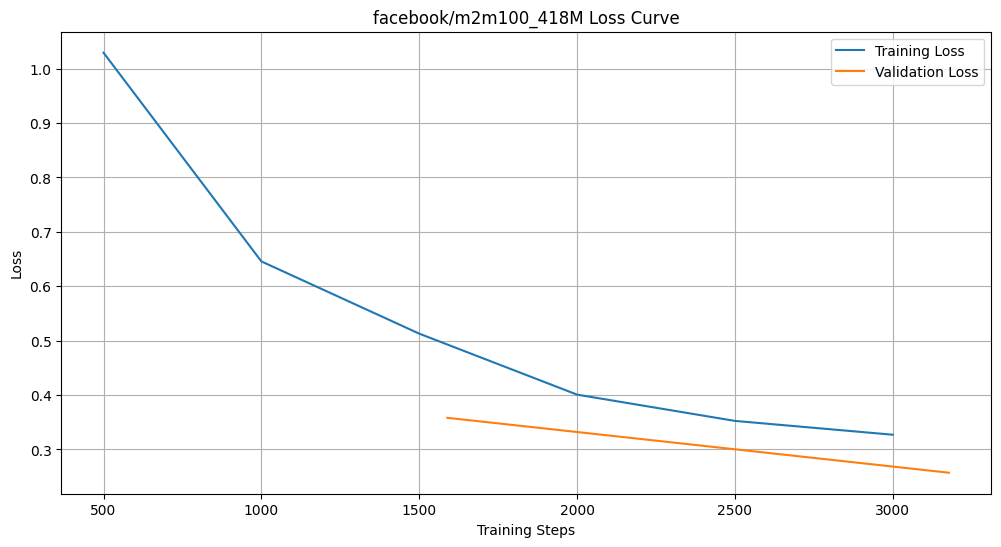

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for training losses
train_df = pd.DataFrame({'step': train_step, 'loss': train_losses})

# Create a DataFrame for evaluation losses
eval_df = pd.DataFrame({'step': eval_step, 'loss': eval_losses})

# Plot the training and evaluation losses
plt.figure(figsize=(12, 6))
sns.lineplot(x='step', y='loss', data=train_df, label='Training Loss')
sns.lineplot(x='step', y='loss', data=eval_df, label='Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title(model_type+' Loss Curve')
plt.legend()
plt.grid(True)
plt.show()
